# Generación datos faltantes

Este notebook sirve para generar datos faltantes en un dataset completo

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
warnings.filterwarnings('ignore', category=SyntaxWarning)  # Porque el \d de \data y \daily lo toma como un valor especial
dataframe = pd.read_csv("..\data\daily-minimum-temperatures-in-me.csv", header=0, index_col=0, parse_dates=True)
series = dataframe.squeeze('columns')
series.head()

<>:2: SyntaxWarning: invalid escape sequence '\d'
<>:2: SyntaxWarning: invalid escape sequence '\d'
C:\Users\alaba\AppData\Local\Temp\ipykernel_15128\1061710041.py:2: SyntaxWarning: invalid escape sequence '\d'
  dataframe = pd.read_csv("..\data\daily-minimum-temperatures-in-me.csv", header=0, index_col=0, parse_dates=True)


Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

Lo pasamos a float

In [3]:
series = series.astype(float)
series.dtypes

dtype('float64')

Dibujamos

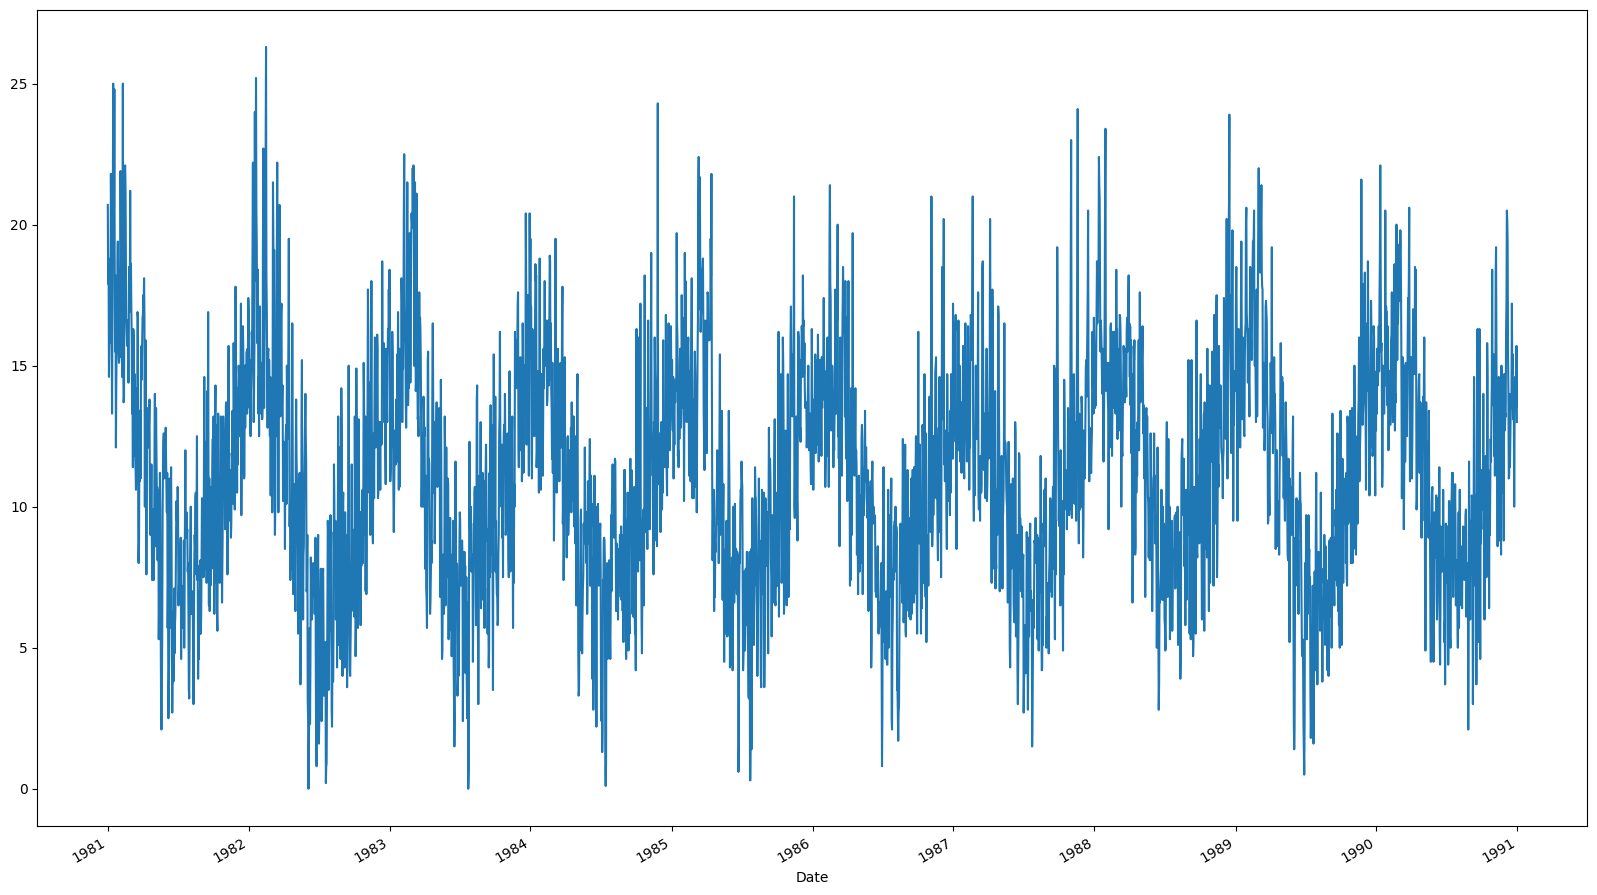

In [4]:
series.plot(figsize=(20,12))
plt.show()

Comprobamos que no haya nulos

c:\Users\alaba\Importante\4º Carrera\TFG\WorkspaceTFG\env\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  self._figure.tight_layout(*args, **kwargs)


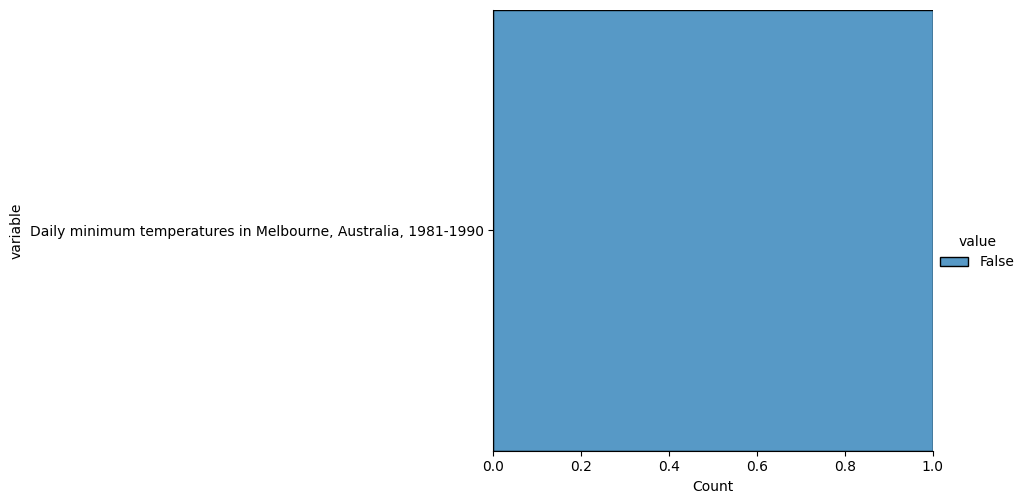

In [5]:
dataframe.isnull().melt().pipe(lambda df: (sns.displot(data=df, y='variable', hue='value', multiple='fill')))

## Insertar nulos en puntos aleatorios

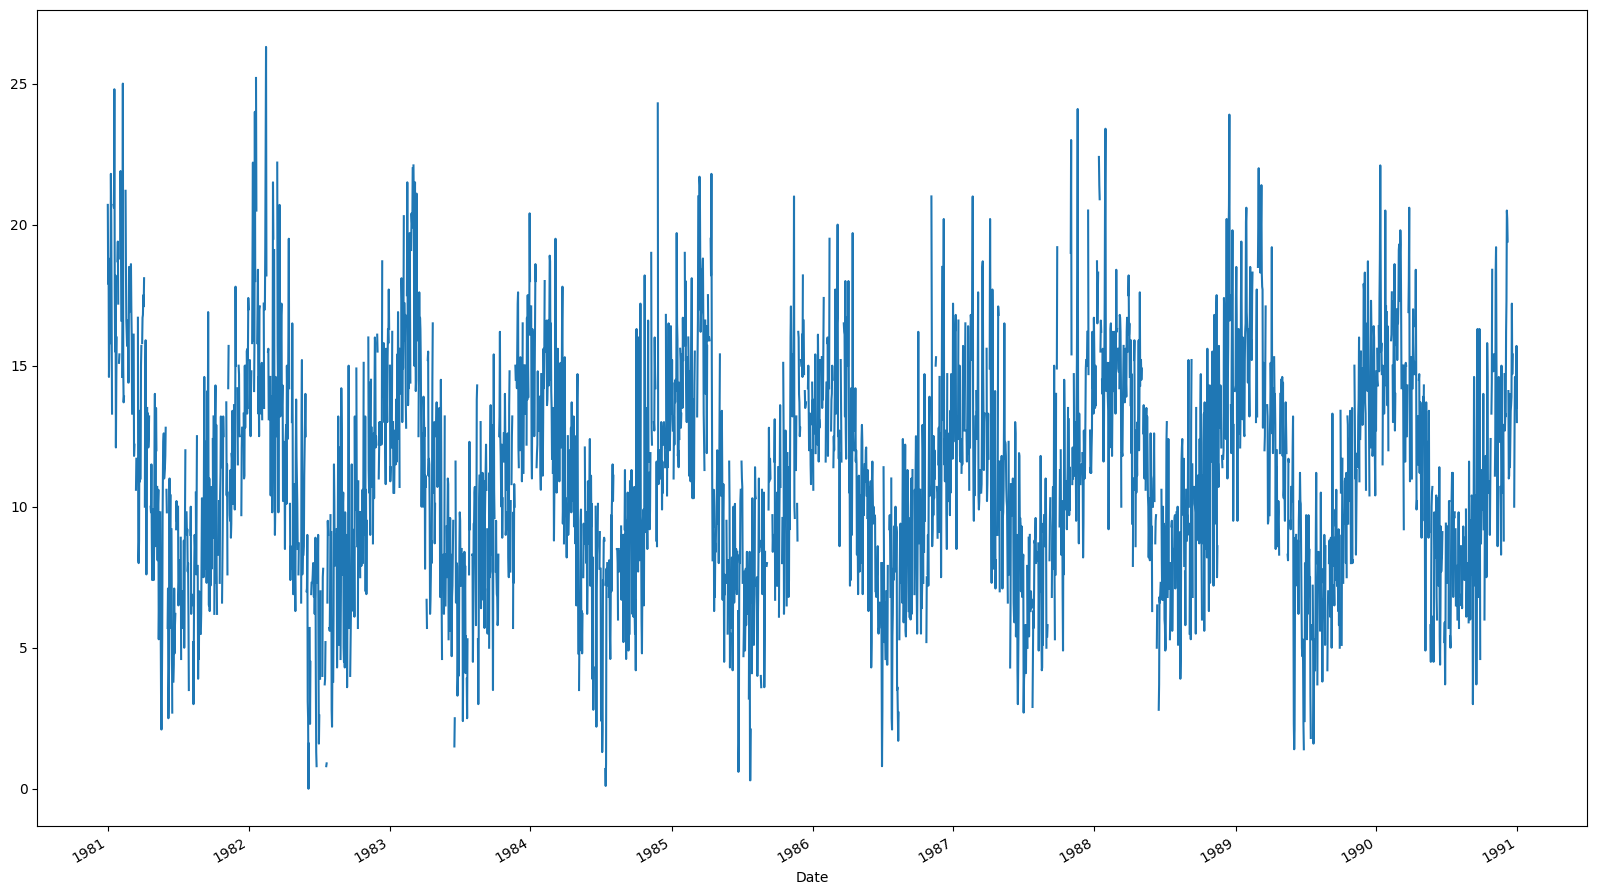

In [ ]:
np.random.seed(27) # para tener resultados repetibles
porcentaje = 0.1

serie_nulos_aleatorios = series.copy()

n_eliminar = int(len(series) * porcentaje)

indices_a_eliminar = np.random.choice(series.index, size=n_eliminar, replace=False)

serie_nulos_aleatorios.loc[indices_a_eliminar] = np.nan

serie_nulos_aleatorios.plot(figsize=(20,12))
plt.show()

In [14]:
serie_nulos_aleatorios[serie_nulos_aleatorios.isna()]

Date
1981-01-06   NaN
1981-01-13   NaN
1981-01-15   NaN
1981-01-25   NaN
1981-01-29   NaN
              ..
1990-11-28   NaN
1990-12-08   NaN
1990-12-21   NaN
1990-12-23   NaN
1990-12-28   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, Length: 547, dtype: float64

In [15]:
len(serie_nulos_aleatorios[serie_nulos_aleatorios.isna()])

547

## Insertar nulos seguidos

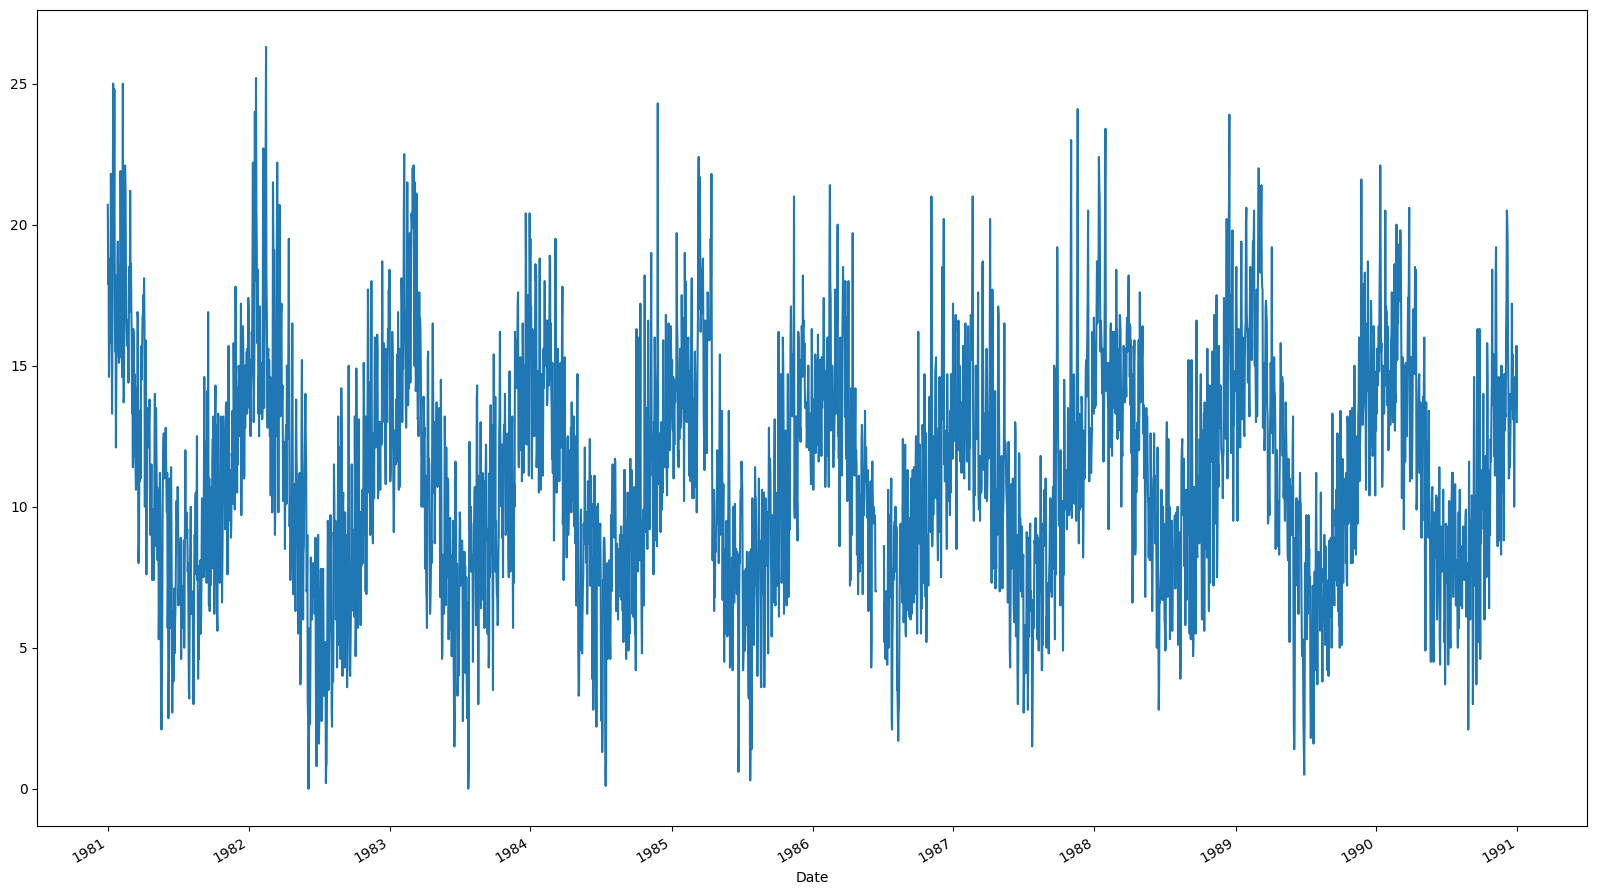

In [ ]:
np.random.seed(27) # para tener resultados repetibles
porcentaje = 0.1
divisiones = 0.05

serie_nulos_seguidos = series.copy()

n_eliminar = int(len(series) * porcentaje)

indices_a_eliminar = np.random.choice(series.index, size=round(n_eliminar*divisiones), replace=False)
len(indices_a_eliminar)


#for i in indices_a_eliminar:
#    serie_nulos_seguidos.iloc[4000-100:4000+100] = np.nan

serie_nulos_seguidos.iloc[2000-int((1/divisiones)/2):2000+int((1/divisiones)/2)] = np.nan
serie_nulos_seguidos.plot(figsize=(20,12))
plt.show()

In [44]:
serie_nulos_seguidos[serie_nulos_seguidos.isna()]

Date
1986-06-15   NaN
1986-06-16   NaN
1986-06-17   NaN
1986-06-18   NaN
1986-06-19   NaN
1986-06-20   NaN
1986-06-21   NaN
1986-06-22   NaN
1986-06-23   NaN
1986-06-24   NaN
1986-06-25   NaN
1986-06-26   NaN
1986-06-27   NaN
1986-06-28   NaN
1986-06-29   NaN
1986-06-30   NaN
1986-07-01   NaN
1986-07-02   NaN
1986-07-03   NaN
1986-07-04   NaN
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

In [98]:
# serie_nulos_seguidos[serie_nulos_seguidos == serie_nulos_seguidos[indices_a_eliminar[0]]]
# serie_nulos_seguidos[indices_a_eliminar[0]]
serie_nulos_seguidos.index.get_loc(indices_a_eliminar[0])


1464

In [100]:
serie_nulos_seguidos.iloc[1464] = np.nan

In [102]:
serie_nulos_seguidos[indices_a_eliminar]

Date
1985-01-05     NaN
1989-07-31     7.6
1989-04-17    10.9
1989-07-25     7.7
1990-09-03     8.6
1985-08-08     9.2
1982-11-04    12.5
1985-10-11    14.7
1982-10-05     4.7
1986-11-03     9.1
1987-04-29    13.5
1982-12-03    10.5
1990-02-07    13.4
1986-03-20    17.0
1990-03-09    13.0
1986-02-03    10.7
1984-11-13    11.1
1987-08-08     8.9
Name: Daily minimum temperatures in Melbourne, Australia, 1981-1990, dtype: float64

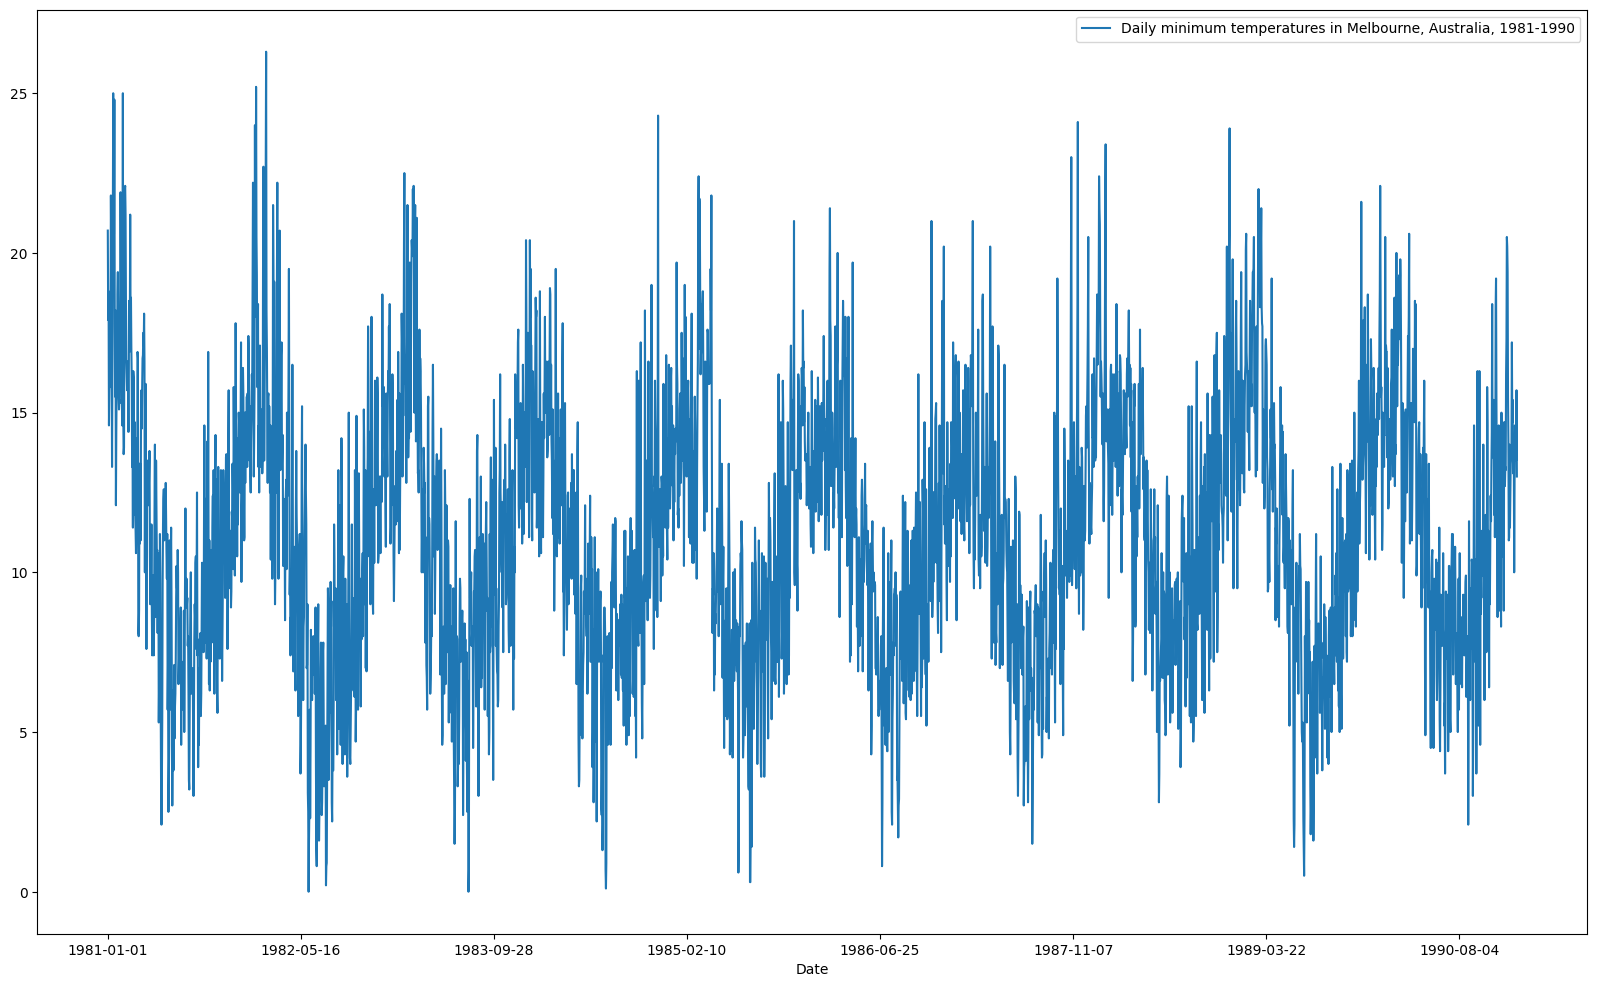

In [73]:
dataframe2 = pd.read_csv("..\data\daily-minimum-temperatures-in-me.csv", header=0, parse_dates=True)
series2 = dataframe2.squeeze('columns')
series2.plot(x='Date',figsize=(20,12))
plt.show()

In [82]:
for x in dataframe2:
    if (x!="Date"):
        dataframe2[x].astype(float)

In [83]:
dataframe2.dtypes

Date                                                              object
Daily minimum temperatures in Melbourne, Australia, 1981-1990    float64
dtype: object

In [97]:
#series.index[0].month
indices_a_eliminar[0]

np.datetime64('1985-01-05T00:00:00.000000000')